In [1]:
import os
import math
import numpy as np
import datetime as dt
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import warnings
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
%matplotlib nbagg
import pickle
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')


### Data import and encoding

In [4]:
def encoding(train_data,test_data=None):
    
    counts = train_data.groupby('mvar48')['default_ind'].count()
    means = train_data.groupby('mvar48')['default_ind'].mean()
    m = 0
    smooth_mean = (counts * means + m * train_data['mvar48'].mean()) / (counts + m)
    enc_48 = dict(smooth_mean)
    train_data['mvar48'] = train_data['mvar48'].map(enc_48)
    train_data = train_data.replace({'C':0,'L':1})
    if test_data==None:
        return train_data
    else:
        test_data = test_data.replace({'C':0,'L':1})
        test_data['mvar48'] = test_data['mvar48'].map(enc_48)
        return train_data, test_data  

In [5]:
data = pd.read_csv('TrainingData.csv', index_col=0)

data.replace('missing', np.nan, inplace=True)
data.replace('na', np.nan, inplace=True)
int_cols = list(set(data.columns) - {'mvar47'})
data[int_cols] = data[int_cols].astype(float)

data_enc = encoding(data)

In [6]:
data_enc.head()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47,mvar48,default_ind
application_key,,,,,,,,,,,,,,,,,,,,,
230032,1696.0,1.6541,0.000,0.0,0.0,0.0,6015.0,322.0,40369.0,18414.0,...,73.780,82.547,0.08696,10.0,0.63899,NaN,0.0,0,0.258550,0.0
230033,1846.0,0.8095,0.000,0.0,0.0,102.0,7532.0,3171.0,18234.0,13664.0,...,99.129,NaN,0.00000,13.0,0.63836,NaN,NaN,1,0.280171,1.0
230034,1745.0,0.4001,0.000,0.0,0.0,NaN,2536.0,NaN,NaN,2536.0,...,NaN,29.290,0.00000,1.0,1.00000,NaN,0.0,0,0.320883,1.0
230035,1739.0,0.2193,0.000,0.0,0.0,1982.0,26440.0,4955.0,20316.0,37013.0,...,96.272,NaN,0.15385,3.0,0.53241,0.0,0.0,1,0.310093,0.0
230036,1787.0,0.0118,0.225,0.0,0.0,5451.0,5494.0,5494.0,7987.0,4696.0,...,115.019,NaN,0.00000,1.0,0.92665,NaN,NaN,1,0.282864,0.0


### Outlier Removal

In [7]:
def RemoveOutlier(data):
    cutoffs_new = [2000,17,150,16,75,40000,1000000,100000,450000,1000000,250000,120000,1000000,0.06*10**9,0.4*10**7,10,12,12,24,25,400,35000,30000,8000,12500,19000,19000,35000,22500,8000,13200,5000,55,10,15,60,50,50,15,275,150,3,55,2,7,5,'random',4000]
    for i in range(len(cutoffs_new)):
        if (i!= 46):
            var = 'mvar' + str(i+1)
            data = data[~(data[var]>cutoffs_new[i])]
    return(data)

In [8]:
data_clean = RemoveOutlier(data_enc)

print('The percentage values removed is {}'.format( round((len(data_enc)-len(data_clean))/len(data_enc)*100, 4) ))

The percentage values removed is 0.794


In [9]:
y = data_clean['default_ind']
X = data_clean.drop('default_ind', axis=1)

### Missing Values

<IPython.core.display.Javascript object>


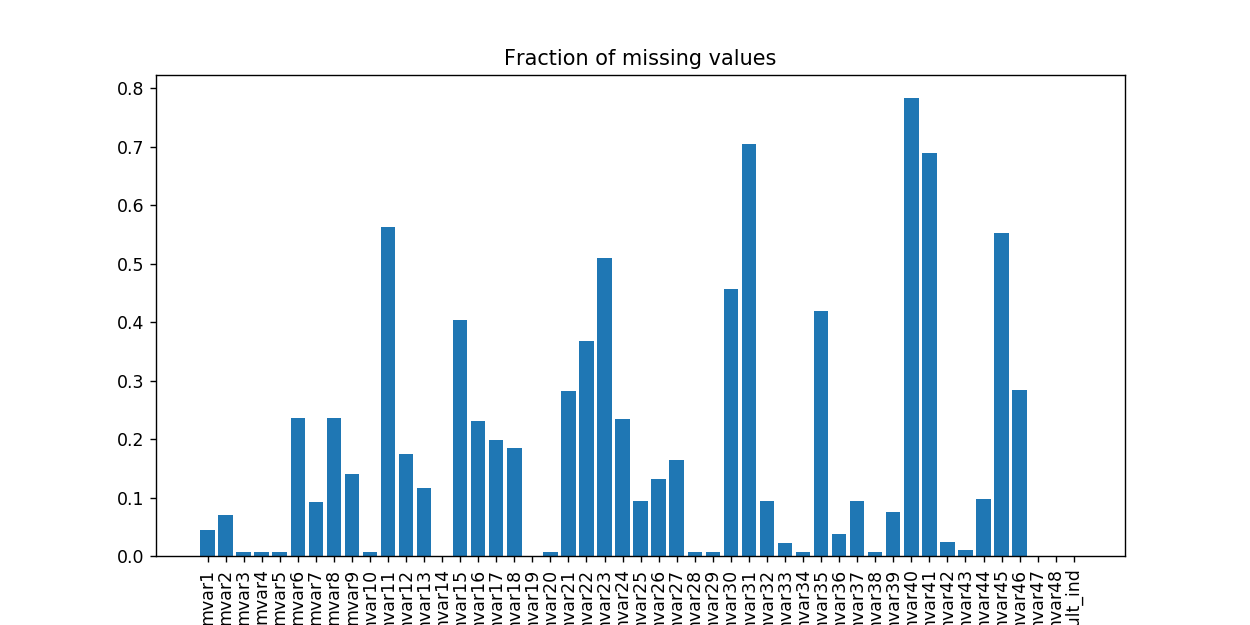

In [10]:
cols = list(data_clean.columns)
nan_per = data_clean.isna().sum(axis=0)/data_clean.shape[0]
plt.figure(figsize=(10,5))
plt.bar(cols,nan_per)
plt.xticks(rotation='vertical')
plt.title('Fraction of missing values')
plt.show()

<IPython.core.display.Javascript object>


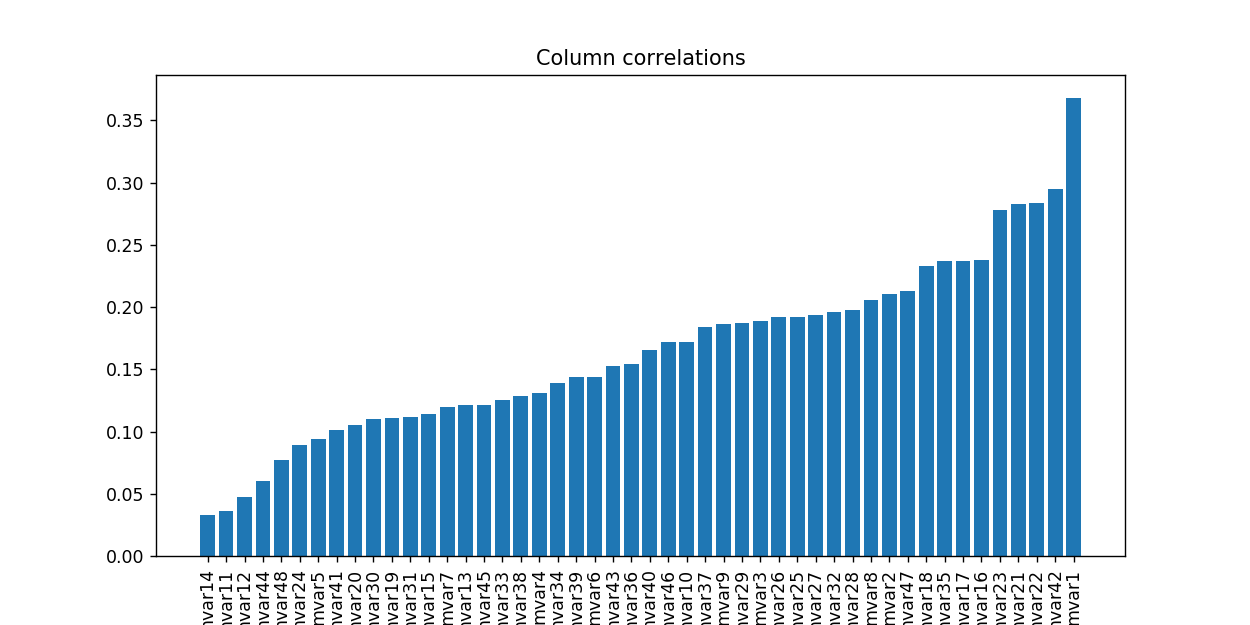

In [12]:
data_corrs = abs(data_clean.corr()['default_ind']).sort_values()

cols = list(data_corrs.keys()[:-1])
plt.figure(figsize=(10,5))
plt.bar(cols, data_corrs.values[:-1])
plt.xticks(rotation='vertical')
plt.title('Column correlations')
plt.show()

In [13]:
print('Columns with too many missing values\n\n', data_clean.columns[np.where(nan_per>0.6)[0]])

Columns with too many missing values

 Index(['mvar31', 'mvar40', 'mvar41'], dtype='object')


### Scaling

In [14]:
X_Scaler = StandardScaler()
X_scaled = pd.DataFrame(X_Scaler.fit_transform(X), columns=X.columns, index=X.index)

In [59]:
pickle.dump(X_Scaler, open('pre_KNN_scaler.sav', 'wb'))

### KNN Imputation

In [15]:
def basic_impute(data, cols, type_='mean'):
    
    if type_ == 'mean':
        return data.fillna(data[cols].mean()) 
    
    if type_ == 'median':
        return data.fillna(data[cols].median())
    
    if type_ =='mode':
        md = data[cols].mode()
        return data.fillna(md.iloc[0]) 
    
    if type_ == 'CF': #CF - Customer friendly
        imp_vals = data.mean()
        v = [40,31,41,45,35,46,24,16,17,18,12,9,39,2,42,43]
        for i in v:
            imp_vals['mvar'+str(i)] = 0
        med = data.median()
        imp_vals['mvar11'] = med['mvar11']
        
        return data.fillna(imp_vals[cols])

In [18]:
def KNN_impute(cols_to_impute, X, train_na_method='median'):
    
    result = X.copy()

    X_nonan = basic_impute(X, X.columns, type_=train_na_method)

    for col in cols_to_impute:

        X_train = X_nonan.loc[~X[col].isna()].drop(col, axis=1)
        y_train = X_nonan.loc[~X[col].isna(), col]

        X_test = X_nonan.loc[X[col].isna()].drop(col, axis=1)
        
        if len(X_test) == 0:
            print('No need to impute', col)
            continue
        
        print(col, ': Number of NaNs -', len(X_test))
        
        # 0.1 % of the data as neighbours
        model = KNeighborsRegressor(int(0.001*len(X_train)))
        model.fit(X_train, y_train)

        result.loc[X_test.index, col] = model.predict(X_test)
        
        print('Imputed for', col)
        
    return result

In [20]:
X_scaled_imputed = KNN_impute(X_scaled.columns, X_scaled, train_na_method='median')

mvar1 : Number of NaNs - 3718
Imputed for mvar1
mvar2 : Number of NaNs - 5842
Imputed for mvar2
mvar3 : Number of NaNs - 534
Imputed for mvar3
mvar4 : Number of NaNs - 534
Imputed for mvar4
mvar5 : Number of NaNs - 534
Imputed for mvar5
mvar6 : Number of NaNs - 19518
Imputed for mvar6
mvar7 : Number of NaNs - 7586
Imputed for mvar7
mvar8 : Number of NaNs - 19525
Imputed for mvar8
mvar9 : Number of NaNs - 11581
Imputed for mvar9
mvar10 : Number of NaNs - 534
Imputed for mvar10
mvar11 : Number of NaNs - 46361
Imputed for mvar11
mvar12 : Number of NaNs - 14449
Imputed for mvar12
mvar13 : Number of NaNs - 9623
Imputed for mvar13
No need to impute mvar14
mvar15 : Number of NaNs - 33232
Imputed for mvar15
mvar16 : Number of NaNs - 19066
Imputed for mvar16
mvar17 : Number of NaNs - 16342
Imputed for mvar17
mvar18 : Number of NaNs - 15212
Imputed for mvar18
mvar19 : Number of NaNs - 5
Imputed for mvar19
mvar20 : Number of NaNs - 534
Imputed for mvar20
mvar21 : Number of NaNs - 23256
Imputed fo

In [21]:
data_scaled_imputed = X_scaled_imputed.copy()
data_scaled_imputed['default_ind'] = y
data_scaled_imputed.to_csv('TrainingDataScaledKNN.csv')

# Start Running From Here

### Rescale

In [24]:
data_scaled_imputed = pd.read_csv('TrainingDataScaledKNN.csv', index_col=0)
X_scaled_imputed = data_scaled_imputed.drop('default_ind', axis=1)
y_scaled_imputed = data_scaled_imputed['default_ind']

In [25]:
X_rescaled = X_Scaler.inverse_transform(X_scaled_imputed)

### Correlation with Output

In [29]:
data_rescaled = pd.DataFrame(X_rescaled, columns=X_scaled_imputed.columns, index=y.index)
data_rescaled['default_ind'] = y

<IPython.core.display.Javascript object>


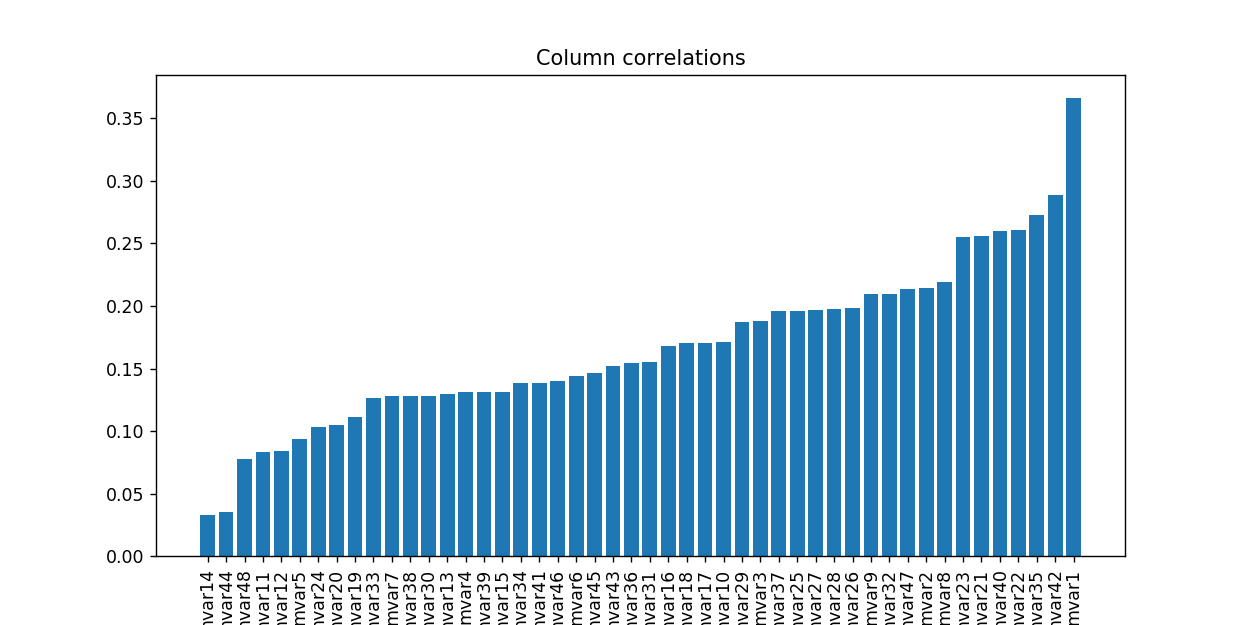

In [31]:
data_corrs = abs(data_rescaled.corr()['default_ind']).sort_values()

cols = list(data_corrs.keys()[:-1])
plt.figure(figsize=(10,5))
plt.bar(cols, data_corrs.values[:-1])
plt.xticks(rotation='vertical')
plt.title('Column correlations')
plt.show()

In [32]:
X_clean = data_rescaled.drop('default_ind', axis=1)

### Interaction Terms

In [52]:
X_inter = X_clean.copy()

columns = X_clean.columns

for i in range(len(columns)):
    f1 = columns[i]
    
    print('Interacting', f1)
    
    if f1=='mvar47':
        continue
        
    for j in range(i):
        f2 = columns[j]
        
        if f2=='mvar47':
            continue
            
        X_inter[str(f1) + '*' + str(f2)] = X[f1]*X[f2]

Interacting mvar1
Interacting mvar2
Interacting mvar3
Interacting mvar4
Interacting mvar5
Interacting mvar6
Interacting mvar7
Interacting mvar8
Interacting mvar9
Interacting mvar10
Interacting mvar11
Interacting mvar12
Interacting mvar13
Interacting mvar14
Interacting mvar15
Interacting mvar16
Interacting mvar17
Interacting mvar18
Interacting mvar19
Interacting mvar20
Interacting mvar21
Interacting mvar22
Interacting mvar23
Interacting mvar24
Interacting mvar25
Interacting mvar26
Interacting mvar27
Interacting mvar28
Interacting mvar29
Interacting mvar30
Interacting mvar31
Interacting mvar32
Interacting mvar33
Interacting mvar34
Interacting mvar35
Interacting mvar36
Interacting mvar37
Interacting mvar38
Interacting mvar39
Interacting mvar40
Interacting mvar41
Interacting mvar42
Interacting mvar43
Interacting mvar44
Interacting mvar45
Interacting mvar46
Interacting mvar47
Interacting mvar48


<IPython.core.display.Javascript object>


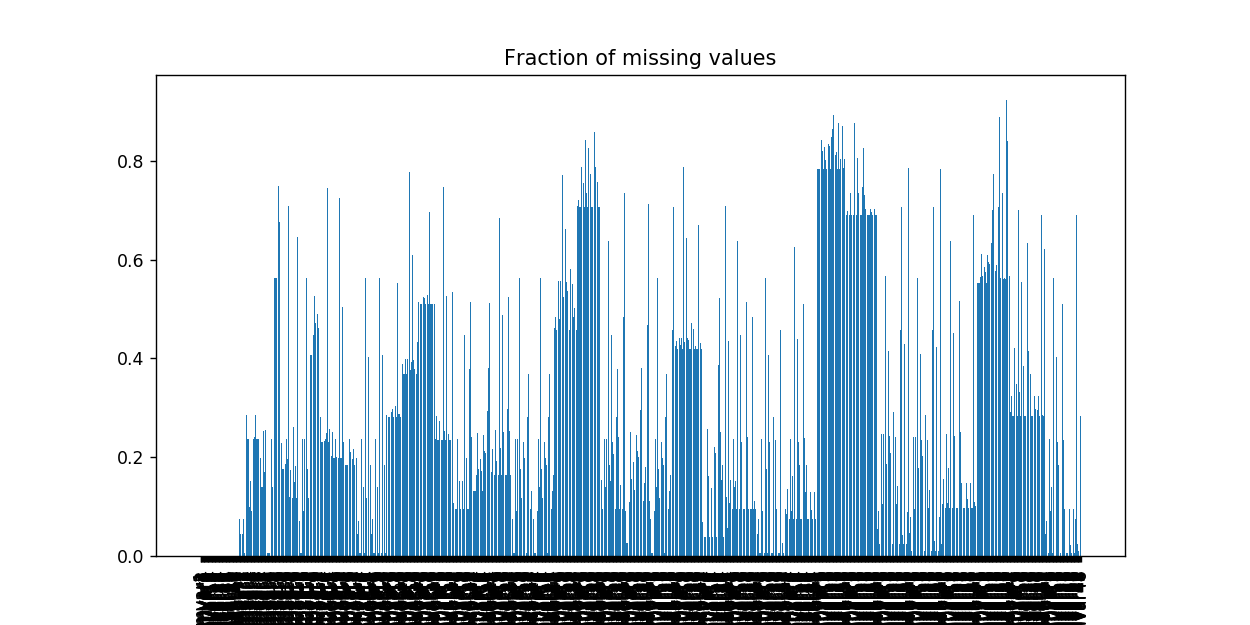

In [53]:
cols = list(X_inter.columns)
nan_per = X_inter.isna().sum(axis=0)/X_inter.shape[0]
plt.figure(figsize=(10,5))
plt.bar(cols,nan_per)
plt.xticks(rotation='vertical')
plt.title('Fraction of missing values')
plt.show()

In [60]:
empty_cols = X_inter.columns[np.where(nan_per>0.5)[0]]
print('Dropped Columns - ', empty_cols)
X_reduced_inter = X_inter.drop(empty_cols, axis=1)

Dropped Columns -  Index(['mvar11*mvar1', 'mvar11*mvar2', 'mvar11*mvar3', 'mvar11*mvar4',
       'mvar11*mvar5', 'mvar11*mvar6', 'mvar11*mvar7', 'mvar11*mvar8',
       'mvar11*mvar9', 'mvar11*mvar10',
       ...
       'mvar46*mvar35', 'mvar46*mvar40', 'mvar46*mvar41', 'mvar46*mvar45',
       'mvar48*mvar11', 'mvar48*mvar23', 'mvar48*mvar31', 'mvar48*mvar40',
       'mvar48*mvar41', 'mvar48*mvar45'],
      dtype='object', length=286)


In [61]:
len(X_reduced_inter.columns)

843

<IPython.core.display.Javascript object>


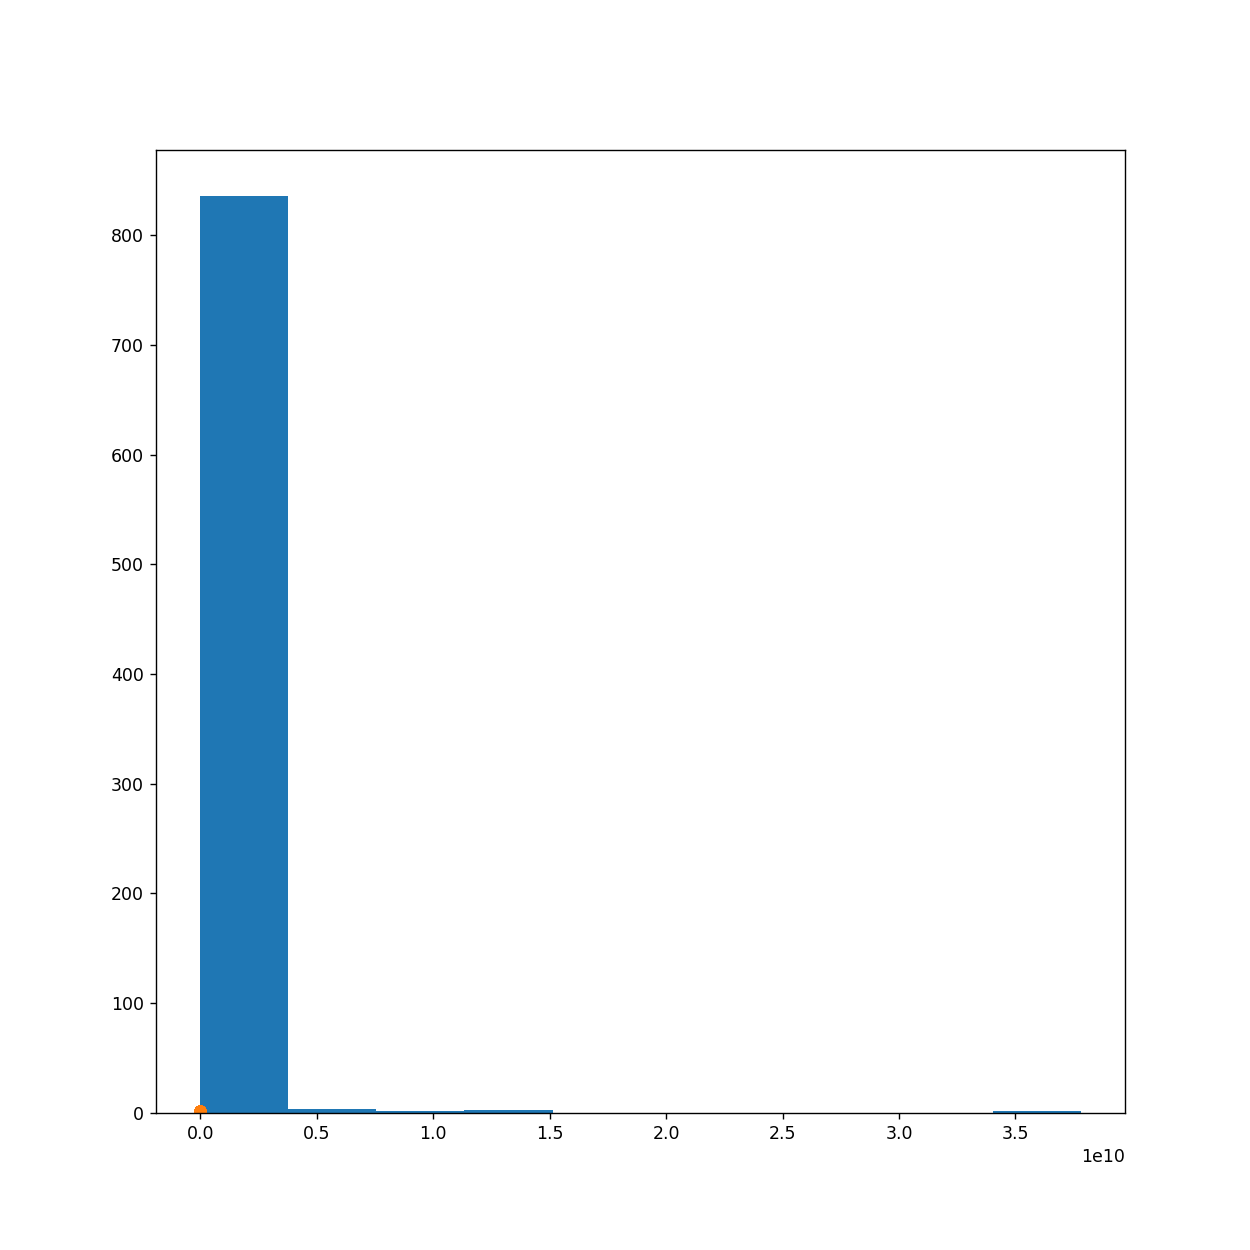

In [62]:
col_avg = X_reduced_inter.mean()
plt.figure(figsize=(10, 10))
plt.hist(col_avg)
plt.show()

In [56]:
# percentile_90 = X_reduced_inter.quantile(0.9)

# print('Saturating variable', end = ' - ')
# for col in percentile_90.keys():
#     print(col, end = ', ')
#     X_reduced_inter.loc[X_reduced_inter[col] > percentile_90[col], col] = percentile_90[col]

Saturating variable - mvar1, mvar2, mvar3, mvar4, mvar5, mvar6, mvar7, mvar8, mvar9, mvar10, mvar11, mvar12, mvar13, mvar14, mvar15, mvar16, mvar17, mvar18, mvar19, mvar20, mvar21, mvar22, mvar23, mvar24, mvar25, mvar26, mvar27, mvar28, mvar29, mvar30, mvar32, mvar33, mvar34, mvar35, mvar36, mvar37, mvar38, mvar39, mvar40, mvar42, mvar43, mvar44, mvar45, mvar46, mvar47, mvar48, mvar2*mvar1, mvar3*mvar1, mvar3*mvar2, mvar4*mvar1, mvar4*mvar2, mvar4*mvar3, mvar5*mvar1, mvar5*mvar2, mvar5*mvar3, mvar5*mvar4, mvar6*mvar2, mvar6*mvar3, mvar6*mvar4, mvar6*mvar5, mvar7*mvar2, mvar7*mvar3, mvar7*mvar4, mvar7*mvar5, mvar8*mvar2, mvar8*mvar3, mvar8*mvar4, mvar8*mvar5, mvar9*mvar2, mvar9*mvar3, mvar9*mvar4, mvar9*mvar5, mvar10*mvar2, mvar10*mvar3, mvar10*mvar4, mvar10*mvar5, mvar11*mvar2, mvar11*mvar3, mvar11*mvar4, mvar11*mvar5, mvar12*mvar2, mvar12*mvar3, mvar12*mvar4, mvar12*mvar5, mvar13*mvar2, mvar13*mvar3, mvar13*mvar4, mvar13*mvar5, mvar14*mvar2, mvar14*mvar3, mvar14*mvar4, mvar14*mvar5, m

mvar43*mvar16, mvar43*mvar17, mvar43*mvar18, mvar43*mvar19, mvar43*mvar20, mvar43*mvar21, mvar43*mvar22, mvar43*mvar23, mvar43*mvar24, mvar43*mvar25, mvar43*mvar26, mvar43*mvar27, mvar43*mvar28, mvar43*mvar29, mvar43*mvar30, mvar43*mvar32, mvar43*mvar33, mvar43*mvar34, mvar43*mvar35, mvar43*mvar36, mvar43/mvar36, mvar43*mvar37, mvar43*mvar38, mvar43*mvar39, mvar43*mvar42, mvar44*mvar1, mvar44*mvar2, mvar44*mvar3, mvar44*mvar4, mvar44*mvar5, mvar44*mvar6, mvar44*mvar7, mvar44*mvar8, mvar44*mvar9, mvar44*mvar10, mvar44*mvar11, mvar44*mvar12, mvar44*mvar13, mvar44*mvar14, mvar44*mvar15, mvar44*mvar16, mvar44*mvar17, mvar44*mvar18, mvar44*mvar19, mvar44*mvar20, mvar44*mvar21, mvar44*mvar22, mvar44*mvar23, mvar44*mvar24, mvar44*mvar25, mvar44*mvar26, mvar44*mvar27, mvar44*mvar28, mvar44*mvar29, mvar44*mvar30, mvar44*mvar32, mvar44*mvar33, mvar44*mvar34, mvar44*mvar35, mvar44*mvar36, mvar44*mvar37, mvar44*mvar38, mvar44*mvar39, mvar44*mvar42, mvar44*mvar43, mvar45*mvar1, mvar45*mvar2, mvar45

### Normalizing

In [63]:
X_reduced_inter.fillna(X_reduced_inter.median(), inplace=True)
X_scaler_new = StandardScaler()
X_scaled_final = pd.DataFrame(X_scaler_new.fit_transform(X_reduced_inter), columns=X_reduced_inter.columns, index=X_reduced_inter.index)

In [66]:
pickle.dump(X_scaler_new, open('post_KNN_scaler.sav', 'wb'))

In [67]:
data_scaled_final = X_scaled_final
data_scaled_final['default_ind'] = y
data_scaled_final.to_csv('TrainingInteractionScaled.csv')

In [92]:
data_scaled_final.head()
cols_list = data_scaled_final.columns
pickle.dump(cols_list, open('cols_list.sav', 'wb'))

### Using VIF to drop interaction terms

In [73]:
VIFs = {}

for var in X_scaled_final.columns[500:]:
    
    var_y = X_scaled_final[var]
    var_X = X_scaled_final.drop(var, axis=1)
    
    linmod = LinearRegression()
    linmod.fit(var_X, var_y)
    R2 = linmod.score(var_X, var_y)
    
    if R2 == 1:
        print('Perfect Correlation:', var_y)
        continue
        
    print('VIF for', var, '=', (1/(1-R2)))
    
    VIFs[var] = 1 / (1 - R2)

VIF for mvar35*mvar8 = 2.651386561669478
VIF for mvar35*mvar9 = 6.4330065039305415
VIF for mvar35*mvar10 = 13.345547147367832
VIF for mvar35*mvar12 = 4.127893918486705
VIF for mvar35*mvar13 = 2.152291450684132
VIF for mvar35*mvar14 = 2.4131398159005055
VIF for mvar35*mvar16 = 29.506918131705955
VIF for mvar35*mvar17 = 442.31644017828273
VIF for mvar35*mvar18 = 416.1579911311307
VIF for mvar35*mvar19 = 335.50544589262506
VIF for mvar35*mvar20 = 335.60405081386614
VIF for mvar35*mvar21 = 10.68727439018201
VIF for mvar35*mvar22 = 9.891583870832775
VIF for mvar35*mvar24 = 3.161449731240643
VIF for mvar35*mvar25 = 13.134404219553495
VIF for mvar35*mvar26 = 11.340948102302315
VIF for mvar35*mvar27 = 12.265224347043748
VIF for mvar35*mvar28 = 2.0381196622640774
VIF for mvar35*mvar29 = 9.718968992968366
VIF for mvar35*mvar32 = 18.92664471678093
VIF for mvar35*mvar33 = 2.4405693228613266
VIF for mvar35*mvar34 = 7.322372515380224
VIF for mvar36*mvar1 = 114.33979523484176
VIF for mvar36*mvar2 = 9

KeyboardInterrupt: 

In [81]:
from sklearn.decomposition import PCA

def PCA_(X, comp=None, var_needed=0.97):

    if comp==None:
    
        pca  = PCA()
        pca.fit(X)
        var = np.cumsum(pca.explained_variance_ratio_)
        N = range(1,len(var)+1)
        comp = np.argwhere(var>var_needed).flatten()[0] + 1

        plt.figure()
        plt.plot(N,var,'-o')
        plt.show()

        print('Components Selected =', comp)

    pca_final = PCA(n_components=comp)
    pca_final.fit(X)
    X_trans = pca_final.transform(X)
    
    return (X_trans, pca_final)

In [82]:
X_pca_train, pca_train = PCA_(X_scaled_final, 200)

In [2]:
final_train_data = pd.DataFrame(X_pca_train, index=X_scaled_final.index)
final_train_data['default_ind'] = y

NameError: name 'X_pca_train' is not defined

In [3]:
final_train_data.to_csv('TrainDataScaledPCA.csv')
pickle.dump(pca_train, open('PCA.sav', 'wb'))

NameError: name 'final_train_data' is not defined

In [5]:
final_train_data = pd.read_csv('TrainDataScaledPCA.csv')
X = final_train_data.drop('default_ind', axis=1)
y = final_train_data['default_ind']

# err = []

for k in range(1, 2):
    model = KMeans(n_clusters=k, n_jobs=-1, verbose=100)
    print('Fitting k =', k)
    model.fit(X)
#     err.append(model.inertia_)
    print('Error =', model.inertia_)

# plt.figure()
# plt.plot(list(range(2, 10)), err)
# plt.xlabel('K')
# plt.ylabel('SSE')
# plt.title('Elbow Plot')
# plt.show()

Fitting k = 1
Error = 776967992611695.8


In [6]:
error = [model.inertia_, 60521653.36684525,
 56426372.6712252,
 54548862.63240543,
 52922506.687133975,
 51590356.35838642,
 50461927.85629836,
 49562206.377077594,
 48759962.12725142]

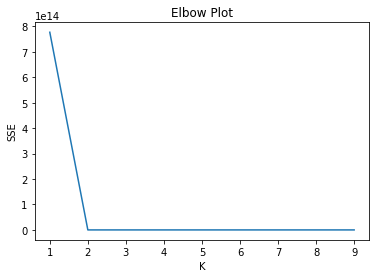

In [8]:
plt.figure()
plt.plot(list(range(1, 10)), error)
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Plot')
plt.show()

In [6]:
cluster_model = KMeans(n_clusters=3, n_jobs=-1, verbose=100)
cluster_model.fit(X)
pickle.dump(cluster_model, open('clustering.sav', 'wb'))

In [9]:
cluster_model

NameError: name 'cluster_model' is not defined